In [ ]:
import pandas as pd 

data=pd.read_csv('finaldata.csv')
print(data.head())

from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
data["business_iden"] = lb_make.fit_transform(data["business_id"])
data["user_iden"] = lb_make.fit_transform(data["user_id"])
print(data.head())

In [2]:
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

data1 = data['stars_y'].value_counts().sort_index(ascending=False)

trace = go.Bar(x = data1.index,
               text = ['{:.1f} %'.format(val) for val in (data1.values / data1.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data1.values,
               )

layout = dict(title = 'Distribution Of {} review-ratings'.format(data.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [3]:

# Number of ratings per book
data2 = data.groupby('business_id')['stars_y'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data2.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per Rest',
                   xaxis = dict(title = 'Number of Ratings Per Rest'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [4]:
data.groupby('business_iden')['stars_y'].count().reset_index().sort_values('stars_y', ascending=False)[:10]

business_iden  stars_y
3150           3150     2662
2017           2017     2592
5118           5118     2320
2042           2042     2258
486             486     2136
2456           2456     2114
155             155     2097
4213           4213     2020
6007           6007     2006
1036           1036     2005

In [6]:

# Number of ratings per user
data3 = data.groupby('user_iden')['stars_y'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data3.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 80,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per User (Clipped at 50)',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [7]:
data.groupby('user_iden')['stars_y'].count().reset_index().sort_values('stars_y', ascending=False)[:10]

user_iden  stars_y
86430       86430     1075
234890     234890      850
80751       80751      839
227916     227916      688
260787     260787      617
233229     233229      534
130470     130470      509
131620     131620      494
180522     180522      494
150247     150247      461

<h2> Reduce Dimensionality </h2>

In [9]:
min_rest_ratings = 50
filter_rest = data['business_iden'].value_counts() > min_rest_ratings
filter_rest = filter_rest[filter_rest].index.tolist()

min_user_ratings = 50
filter_users = data['user_iden'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_new = data[(data['business_iden'].isin(filter_rest)) & (data['user_iden'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(data.shape))
print('The new data frame shape:\t{}'.format(df_new.shape))

The original data frame shape:	(1230663, 59)
The new data frame shape:	(179573, 59)


In [10]:
data=data[['user_iden','business_iden','name','stars_y']]

In [11]:
print(data.head())

   user_iden  business_iden      name  stars_y
0     265005           5743  Club Red      4.0
1      99709           5743  Club Red      5.0
2      90994           5743  Club Red      2.0
3     115446           5743  Club Red      5.0
4     263042           5743  Club Red      2.0


In [13]:
from surprise import Reader, Dataset
reader = Reader()
data = Dataset.load_from_df(data[['user_iden', 'business_iden', 'stars_y']], reader)

In [14]:
from surprise.model_selection import train_test_split

trainset, testset = train_test_split(data, test_size=0.25)

In [15]:
# We'll use the SVD algorithm.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from surprise import SVD,SVDpp, accuracy,SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering
algo = SVD()
# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)

In [16]:
predictions = algo.test(testset)

In [17]:
accuracy.rmse(predictions)

RMSE: 1.2728


1.2728306958296314

In [18]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0

In [19]:
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

In [20]:
df.head()

uid   iid  rui       est                    details  Iu   Ui       err
0  338936  1233  4.0  3.781484  {'was_impossible': False}  17   90  0.218516
1  284536  4922  1.0  3.152855  {'was_impossible': False}   0  317  2.152855
2   84699  2196  5.0  4.378029  {'was_impossible': False}   0   89  0.621971
3  144926  5472  3.0  3.652687  {'was_impossible': False}   6  359  0.652687
4   31179  3084  2.0  4.116612  {'was_impossible': False}  10  236  2.116612

In [ ]:
!pip install plotly --user

In [25]:
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [27]:
best_predictions


uid   iid  rui  est                    details   Iu   Ui  err
159538  318677    20  5.0  5.0  {'was_impossible': False}   61  486  0.0
137633  208303  5149  5.0  5.0  {'was_impossible': False}   23  226  0.0
137623  302693  4826  1.0  1.0  {'was_impossible': False}   21  116  0.0
137618  194265  5151  5.0  5.0  {'was_impossible': False}   39  252  0.0
279870   57272  4084  5.0  5.0  {'was_impossible': False}    5   57  0.0
18252   323087  1298  5.0  5.0  {'was_impossible': False}  194  244  0.0
188579  260653  3900  5.0  5.0  {'was_impossible': False}   32  107  0.0
84946   334795  1596  1.0  1.0  {'was_impossible': False}    1  117  0.0
137567  305982  2744  5.0  5.0  {'was_impossible': False}   10  130  0.0
188616  135739  2705  5.0  5.0  {'was_impossible': False}    3  142  0.0

In [28]:
worst_predictions

uid   iid  rui  est                    details   Iu    Ui  err
267929   10566  1596  5.0  1.0  {'was_impossible': False}    4   117  4.0
256245  153088  3150  1.0  5.0  {'was_impossible': False}    5  1975  4.0
133411   83358   455  1.0  5.0  {'was_impossible': False}    9  1044  4.0
79355   147512  4208  1.0  5.0  {'was_impossible': False}    5   256  4.0
100417  294860  3948  1.0  5.0  {'was_impossible': False}    2   166  4.0
121391  274230  3533  1.0  5.0  {'was_impossible': False}   10    74  4.0
302226  284700  1358  1.0  5.0  {'was_impossible': False}  100   128  4.0
232303  264112  2971  1.0  5.0  {'was_impossible': False}   52   376  4.0
94982   103492   708  1.0  5.0  {'was_impossible': False}   14   225  4.0
25000   203166  2527  1.0  5.0  {'was_impossible': False}   15   533  4.0

<IPython.core.display.Javascript object>


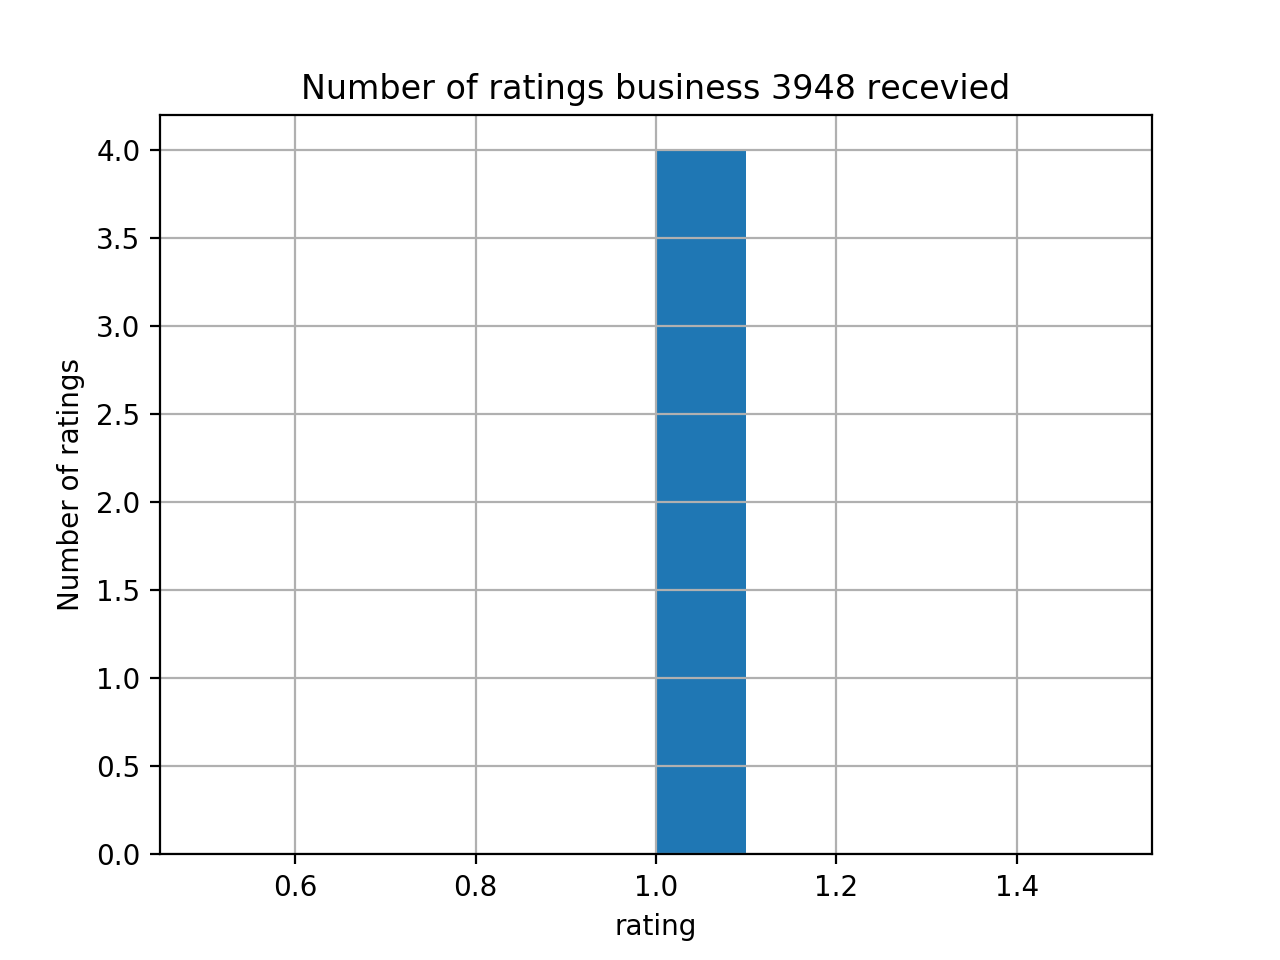

In [31]:
import matplotlib.pyplot as plt

df_new.loc[df_new['business_iden'] == 1596]['stars_y'].hist()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings business 3948 recevied')
plt.show();